# Models: Prophet

## 1. Loaded modules and preparing data

In [1]:
import pandas as pd
import numpy as np

# Facebook Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import fbprophet.plot

# Plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

First, we load in the hourly data created in the wrangling step.

In [2]:
df = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
df

,kWh
timestamp,
2017-01-01 00:00:00,7985.77
2017-01-01 01:00:00,7780.45
2017-01-01 02:00:00,7676.35
2017-01-01 03:00:00,7722.80
2017-01-01 04:00:00,7716.57
...,...
2019-12-31 20:00:00,11171.96
2019-12-31 21:00:00,10570.42
2019-12-31 22:00:00,10077.17


Next, we rename the columns for use in the models below. The models below expect the data to have a `ds` column (representing the timestamps) and a `y` column (representing the values of the time series).

In [3]:
df.index.names = ['ds']
df.rename(columns={'kWh':'y'}, inplace=True)

We divide the data into three sets: train, validation, and test sets. The test set starts from the timestamp 2019-12-01. In the remaing portion of the data, the first 80% of it is used for training, and the remaining 20% is used for validation. However, we may choose not to generate the validation set if it's not necessary.

In [4]:
def train_val_test_split(df, validation=True):
    train_end = '2019-12-01 00:00:00'

    train_val = df.loc[:train_end, :]
    test_df = df.loc[train_end:, :]

    # Let the ds indexing column be its own column as is required by the models below.
    for df in [train_val, test_df]:
        df.reset_index(inplace=True)
        
    if not validation:
        return train_val, test_df

    n = len(train_val)
    cutoff = int(n*0.8)

    train_df = train_val[:cutoff]
    val_df = train_val[cutoff:]
    return train_df, val_df, test_df

In [5]:
train_df, val_df, test_df = train_val_test_split(df)

## Prophet

### Description

Prophet is a open-source project from Facebook that aims to model time series data and make reliable forecasts. Essentially, a Prophet model is an additive model with several components: a seasonal component with multiple levels (e.g., yearly, weekly, daily, and user-defined seasonalities), a trend component which can be highly non-linear, and holiday effects. Prophet fits models with Stan, a probabilistic programming framework. Prophet estimates the parameters with maximum a posteriori estimates by default.


The model can typically be expressed with the following formula:

$$
\begin{aligned}
y_t=g(t)+s(t)+h(t)
\end{aligned}
$$

where:

* $y_t$ is the time series

* $g(t)$ is a (possibly smooth and nonlinear) function of the trend

* $s(t)$ represents the seasonal, periodic changes (e.g., yearly and weekly seasonalities)

* $h(t)$ models the effects of holidays, whose schedule may be irregular.

For more information, please see the article ([Taylor et al., 2018](https://peerj.com/preprints/3190/)).

### Some functions

In this subsection, we define several functions to help with modeling with Prophet.

In [6]:
def to_exp(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.exp)
    return res


def to_log(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.log)
    return res


def plot(forecast, train, x1,x2):
    """
    Plots two time series 'forecast' and 'train' in one plot mainly to compare them.
    Also plots the first time series against the second time series to determine 
    how similar they are. x1 is the starting time point and x2 is the ending time point.
    """
    yhat = forecast.set_index('ds').loc[x1:x2, 'yhat']
    y = train.set_index('ds').loc[x1:x2, 'y']
    plt.figure(figsize=(15,7))
    plt.plot(yhat, 'o-', label='Estimated')
    plt.plot(y, 'o', label='True')
    lower = forecast.set_index('ds').loc[x1:x2, 'yhat_lower']
    upper = forecast.set_index('ds').loc[x1:x2, 'yhat_upper']
    plt.fill_between(yhat.index, lower, upper, alpha=0.2)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.scatter(x=y, y=yhat)
    min_x = int(np.floor(np.min([yhat.min(), y.min()]))) 
    max_x = int(np.ceil(np.max([yhat.max(), y.max()])))
    r = range(min_x,max_x)
    plt.plot(r, r, 'r', label='y=x')
    plt.title('True (x-axis) against estimated (y-axis)')
    plt.legend()
    plt.show()
    

def acf_res(forecast, train):
    """
    Plots a autocorrelation plot of the residuals (y-true minus y-predicted) for training data.
    """
    date_range = train['ds']
    res = train.set_index('ds')['y'] - forecast.set_index('ds').loc[date_range, 'yhat']
    plot_acf(res)

    
def is_spring(ds):
    return ds.month in [3,4,5]

    
def is_summer(ds):
    """
    Determines whethere a timestamp ds is in the summer or not.
    """
    return ds.month in [6,7,8]


def is_winter(ds):
    """
    Determines whether a timestamp ds is in the winter.
    """
    return ds.month in [12,1,2]


def is_autumn(ds):
    return ds.month in [9,10,11]
    
    
def is_weekend(ds):
    """
    Determines whether a timestamp ds is in the weekend.
    """
    return ds.day_name() in ['Saturday', 'Sunday']


def is_weekday(ds):
    """
    Determines whether a timestamp ds is a weekday.
    """
    return not is_weekend(ds)


def is_winter_weekday(ds):
    """
    Determines whether a timestamp ds is a winter weekday.
    """
    return is_winter(ds) and is_weekday(ds)


def is_winter_weekend(ds):
    """
    Determines whether a timestamp ds is a winter weekend.
    """
    return is_winter(ds) and is_weekend(ds)


def is_summer_weekday(ds):
    """
    Determines whether a timestamp ds is a summer weekday.
    """
    return is_summer(ds) and is_weekday(ds)


def is_summer_weekend(ds):
    """
    Determines whether a timestamp ds is a summer weekend.
    """
    return is_summer(ds) and is_weekend(ds)


def is_first_half(ds):
    """
    Determines whether a timestamp is in the first half of a year (spring-summer)
    """
    return (ds.month >= 2 and ds.month <= 7)


def is_second_half(ds):
    """
    Determines whether a timestamp is in the second half of a year (autumn-summer)
    """
    return not is_first_half(ds)


def is_spring_weekday(ds):
    return is_spring(ds) and is_weekday(ds)


def is_spring_weekend(ds):
    return is_spring(ds) and is_weekend(ds)


def is_autumn_weekday(ds):
    return is_autumn(ds) and is_weekday(ds)


def is_autumn_weekend(ds):
    return is_autumn(ds) and is_weekend(ds)


def add_custom_seasonality(df):
    """
    Augments the dataframe df with several columns determining
    whether the corresponding datapoints belong to different seasoonalities. 
    """
    df = df.assign(
                       spring_weekday = df['ds'].apply(is_spring_weekday),
                       spring_weekend = df['ds'].apply(is_spring_weekend),
                       summer_weekday = df['ds'].apply(is_summer_weekday),
                       summer_weekend = df['ds'].apply(is_summer_weekend),
                       autumn_weekday = df['ds'].apply(is_autumn_weekday),
                       autumn_weekend = df['ds'].apply(is_autumn_weekend),
                       winter_weekday = df['ds'].apply(is_winter_weekday),
                       winter_weekend = df['ds'].apply(is_winter_weekend),
                       summer = df['ds'].apply(is_summer),
                       winter = df['ds'].apply(is_winter),
                       weekend = df['ds'].apply(is_weekend),
                       weekday = df['ds'].apply(is_weekday)
                  )
    return df


def mape(ytrue, ypred):
    """
    calculates the mean absolute percentage error, for use below
    """
    return np.mean(np.abs(1-ypred/ytrue))

## Modeling

### Default Prophet model

First, we try the default Prophet model, that is, we do not specify any further options and use the default arguments for its `fit` method. In a default Prophet model for hourly time series, there is a yearly seasonality, weekly seasonality, and daily seasonality, The growth is linear and the components are additive.

In [1]:
model_default = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
model_default.fit(train_df)

NameError: name 'Prophet' is not defined

After fitting the `model_default` on the train dataset, we use it to make forecasts on the validation dataset.

In [8]:
future = model_default.make_future_dataframe(periods=len(val_df), freq='H')
forecast = model_default.predict(future)

The plot below shows the fitted values (blue curve) against the true data (black dots). The blue bands are 95% uncertainty intervals.

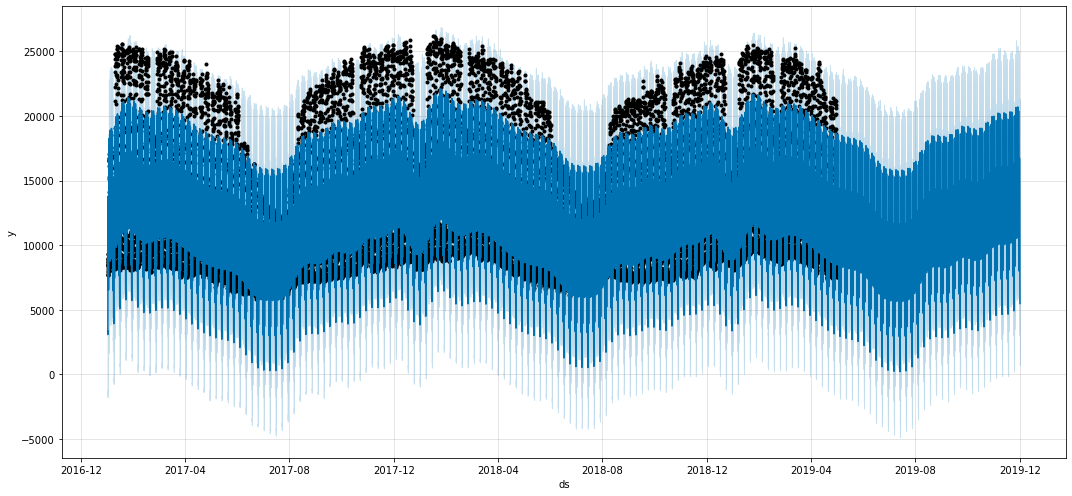

In [9]:
fig1 = model_default.plot(forecast, figsize=(15,7))

As we can see, the fit is not satisfactory as the model underestimates and overestimates the data at regular intervals (the blue line is consistently lower and higher than the black "curve" (dots), even if the 95% intervals cover the black dots.

We should zoom in on a time period to investigate the fits.

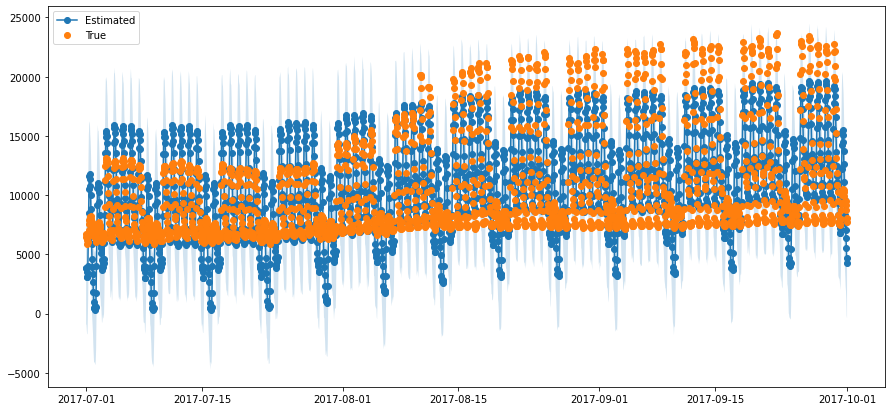

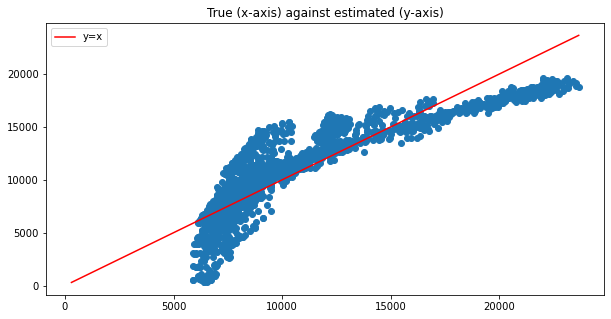

In [10]:
plot(forecast, train_df, '2017-07', '2017-09')

Additionally, we investigate the autocorrelation plot of the residuals, i.e., true value minus predicted value.

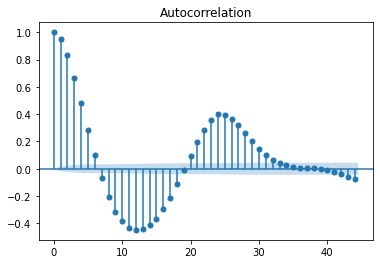

In [11]:
acf_res(forecast, train_df)

In a satisfactory model, the autocorrelations should be very low (they should lie within the blue 95% confidence band). However, in the plot above, not only are the autocorrelations high, they also lie outside the band.

From all plots above, we can conclude that the model regularly underestimates as well as overestimates the data, and that the model is not satisfactory.

Next, we plot some components of the models: the trend and the seasonalities.

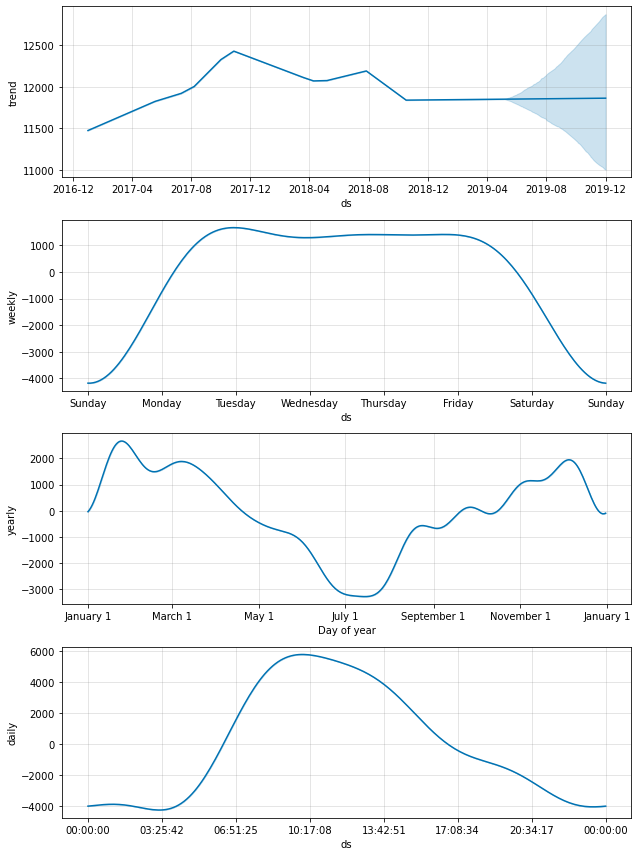

In [12]:
fig2 = model_default.plot_components(forecast)

Remarks: the default model correctly identifies that during a day, the electricity demand typically reaches its daily peak around noon (the time zone of the data is in UTC, but the origin of the data is in UTC+2 or UTC+3 time zone). It also correctly identifies that in a year, the demand typically reaches its lowest in the summer. In contrast, the demand is typically very high in the winter. In addition, in a week, the model correctly identifies that the demand is lower in weekends and higher in weekdays.

### Custom Prophet model

#### Fitting the model

After a careful look at the data, we observe that in the summer, the within-day variation in electricity demand seems to be smaller than that in the winter. This suggests that this variation has a multiplicative effect. In addition, we notice that the demand is always lower in the weekend than during the weekdays. In addition, within each year, we see that there is a decreasing trend in the first half of the year and an increasing trend in the second half of the year.

In light of the observations above, we add our custom seasonalities. First of all, we add seasonalities for weekends and weekdays for each season (winter, spring, summer, autumn). However, we transform the data by logarithmizing the values because we wish the seasonalities to have a multiplicative effect on each other as log of a product is a sum:

$$
\begin{aligned}
y_t&=g(t)\times s(t)\times h(t)\\
\Rightarrow \log{y_t}&=\log{g(t)}+\log{s(t)}+\log{h(t)}
\end{aligned}
$$

In [13]:
train_df, val_df, test_df = train_val_test_split(to_log(df, ['y']))
train_df = add_custom_seasonality(train_df)
val_df = add_custom_seasonality(val_df)
test_df = add_custom_seasonality(test_df)
future = add_custom_seasonality(future)

In [14]:
a = pd.date_range(start='2017-01-01', end='2017-01-08', freq='1D').to_series()
b = pd.date_range(start='2017-12-20', end='2018-01-08', freq='1D').to_series()
c = pd.date_range(start='2018-12-20', end='2019-01-08', freq='1D').to_series()
d = pd.date_range(start='2019-12-20', end='2020-01-01', freq='1D').to_series()

# In Finland, usually Christmas and New year holidays last acoording to the date ranges above
christmas_newyear = pd.DataFrame({
    'holiday': 'christmas_newyear',
    'ds': pd.concat([a, b, c, d], axis=0).values
})

In [15]:
def better_prophet():
    model_improved = Prophet(
        changepoint_prior_scale=0.5,
        daily_seasonality=False,
        holidays = christmas_newyear,
        interval_width=0.95)

    # The higher the fourier_order, the more wiggly the seasonality component becomes
    model_improved.add_seasonality(name='spring_weekday', period=1, fourier_order=12, condition_name='spring_weekday')
    model_improved.add_seasonality(name='spring_weekend', period=1, fourier_order=12, condition_name='spring_weekend')
    model_improved.add_seasonality(name='summer_weekday', period=1, fourier_order=12, condition_name='summer_weekday')
    model_improved.add_seasonality(name='summer_weekend', period=1, fourier_order=12, condition_name='summer_weekend')
    model_improved.add_seasonality(name='autumn_weekday', period=1, fourier_order=12, condition_name='autumn_weekday')
    model_improved.add_seasonality(name='autumn_weekend', period=1, fourier_order=12, condition_name='autumn_weekend')
    model_improved.add_seasonality(name='winter_weekday', period=1, fourier_order=12, condition_name='winter_weekday')
    model_improved.add_seasonality(name='winter_weekend', period=1, fourier_order=12, condition_name='winter_weekend')
    model_improved.add_country_holidays(country_name='Finland')
    return model_improved

In [16]:
model_improved = better_prophet()
model_improved.fit(train_df)

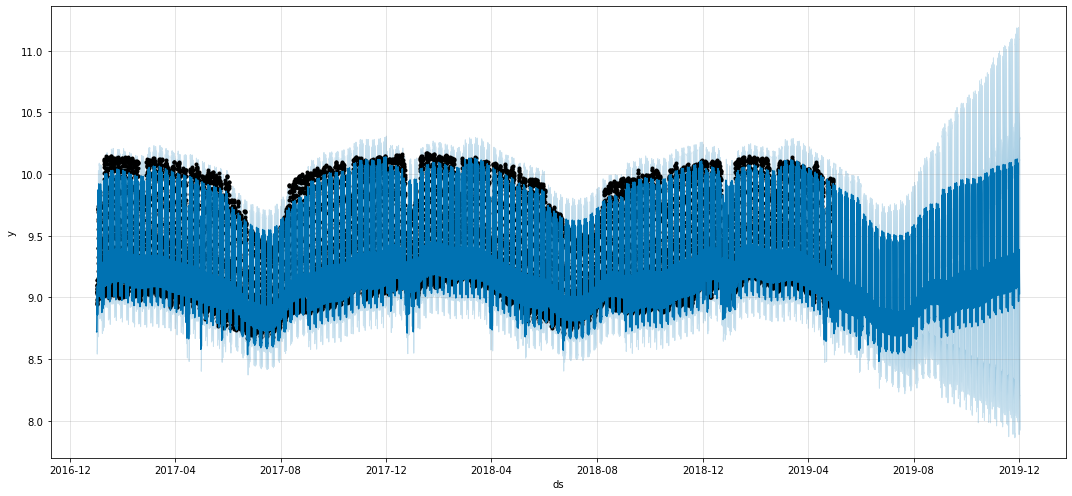

In [17]:
forecast_improved = model_improved.predict(future)

fig1 = model_improved.plot(forecast_improved, figsize=(15,7))

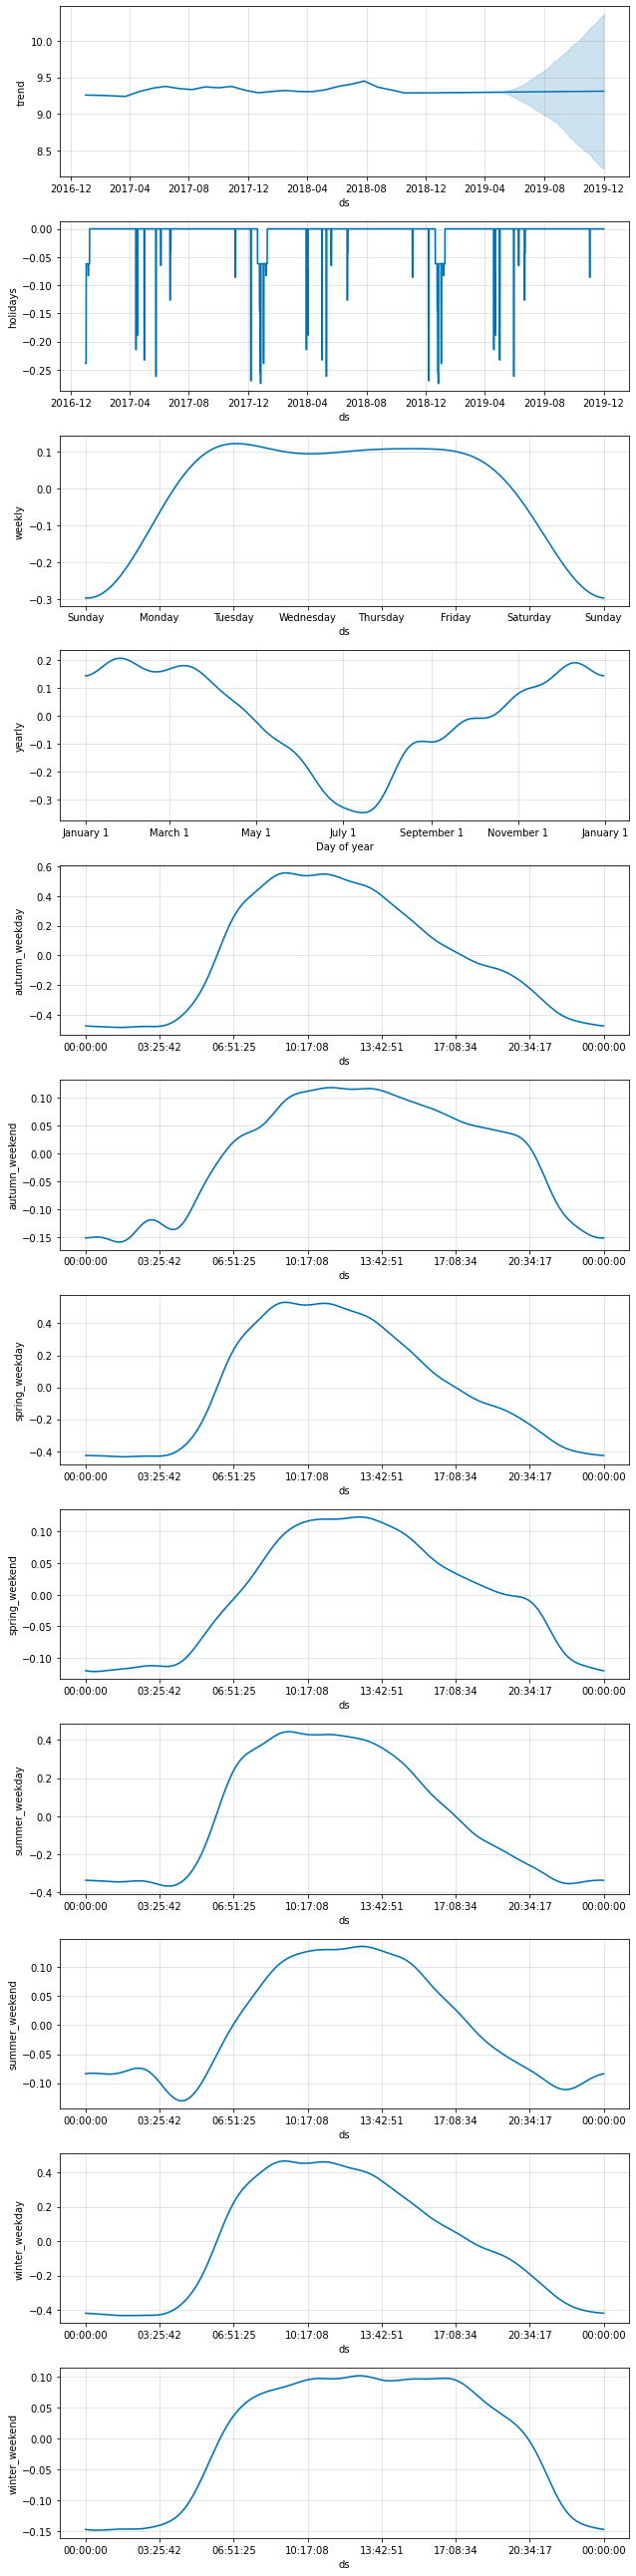

In [18]:
fig2 = model_improved.plot_components(forecast_improved)

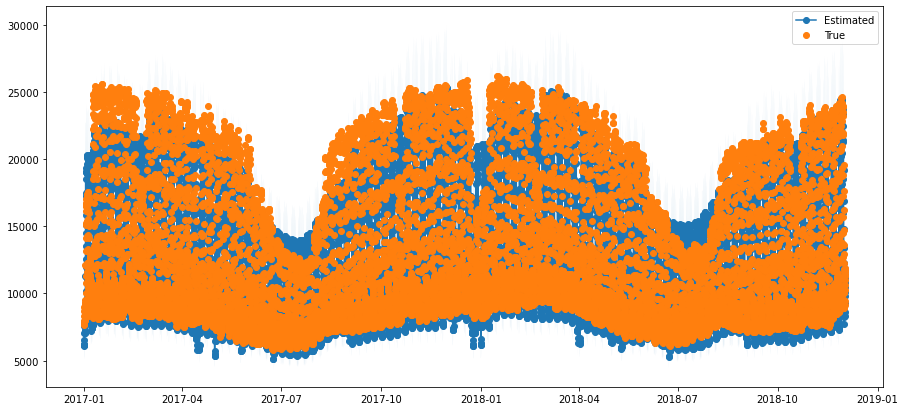

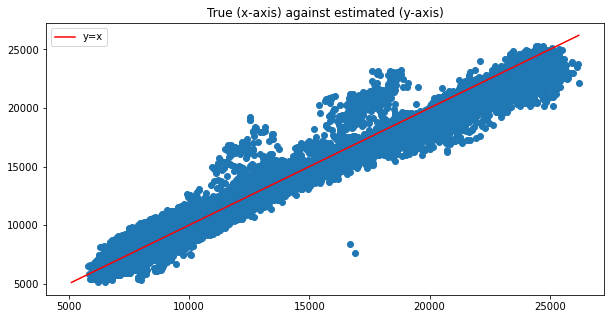

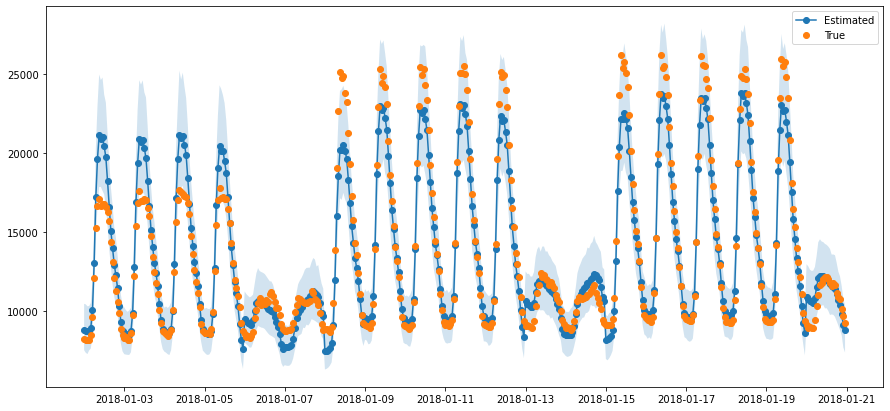

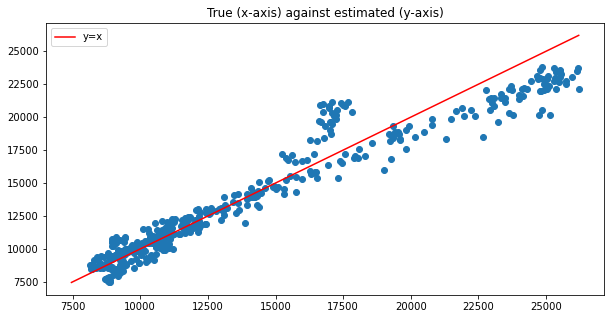

In [19]:
plot(to_exp(forecast_improved, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2017-01-01', '2018-12-01')
plot(to_exp(forecast_improved, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2018-01-02', '2018-01-20')

Although the model consistently overpredicts in the summer, the forecasts are quite satisfactory in other seasons.

### Cross-validation

Cross-validation on time series data is different from that on common non time-series data because there is a time structure which must not be broken with random partitioning used in normal cross-validation methods. This is why Prophet has its own cross-validation methods.

The cross-validation procedure is as follows. First, the model is trained on the first 8766 hours of the data (initial). Then, it forecasts the next 720 hours of data (horizon). After that, the model is trained on the first 8766 hours plus the next 1440 hours (period by default) and make predictions on the next 720 hours after that 360 hours. This procedure continues (training data has 1440-hour increments and forecasts are made on the next 720 hours) until there is not enough data left to do this.

In [20]:
df_cv = cross_validation(model_improved, initial='8766 hours', period='1440 hours', horizon='720 hours', parallel="processes")

INFO:fbprophet:Making 8 forecasts with cutoffs between 2018-02-06 04:00:00 and 2019-04-02 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000263074E5970>


In [21]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days 00:00:00,0.003984,0.063118,0.049762,0.005374,0.004232,0.989583
1,3 days 01:00:00,0.003986,0.063131,0.049745,0.005373,0.004232,0.989583
2,3 days 02:00:00,0.004112,0.064126,0.049916,0.005392,0.004232,0.987847
3,3 days 03:00:00,0.004625,0.068004,0.050784,0.005487,0.004232,0.984375
4,3 days 04:00:00,0.005468,0.073946,0.052083,0.005627,0.004228,0.980903
...,...,...,...,...,...,...,...
644,29 days 20:00:00,0.015032,0.122604,0.092353,0.009923,0.007813,0.935764
645,29 days 21:00:00,0.014958,0.122305,0.092107,0.009895,0.007787,0.935764
646,29 days 22:00:00,0.014924,0.122164,0.091978,0.009880,0.007787,0.935764
647,29 days 23:00:00,0.014866,0.121925,0.091713,0.009850,0.007787,0.935764


We focus on the mean absolute percentage error (MAPE). The absolute percentage error is the absolute value of the proportion of the difference between the true value and the predicted value to the true value. MAPE is a mean of those errors:

$$
\begin{aligned}
\text{MAPE}=\frac{1}{n}\sum_{t=1}^n\left|\frac{y-\hat{y}}{y}\right|
\end{aligned}
$$

This error function can be measured in percentages and is thus easy to understand. The lower this error is, the better the prediction.

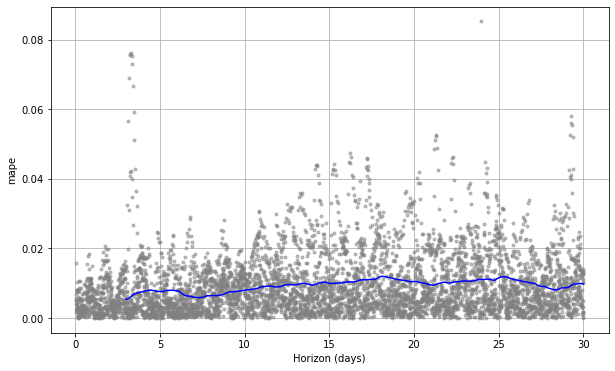

In [22]:
fig_cv = plot_cross_validation_metric(df_cv, metric='mape')

It seems that this model is good enough.

## Model selection

We could finally evaluate the better model's performance on the test set by retraining it on the aggregation of the train set and the validation set.

In [23]:
train, test = train_val_test_split(to_log(add_custom_seasonality(df.reset_index()), ['y']).set_index('ds'), validation=False)
model_final = better_prophet()
model_final.fit(train)

In [24]:
future = model_final.make_future_dataframe(periods=len(test), freq='H')
future = add_custom_seasonality(future)
forecast = model_final.predict(future)

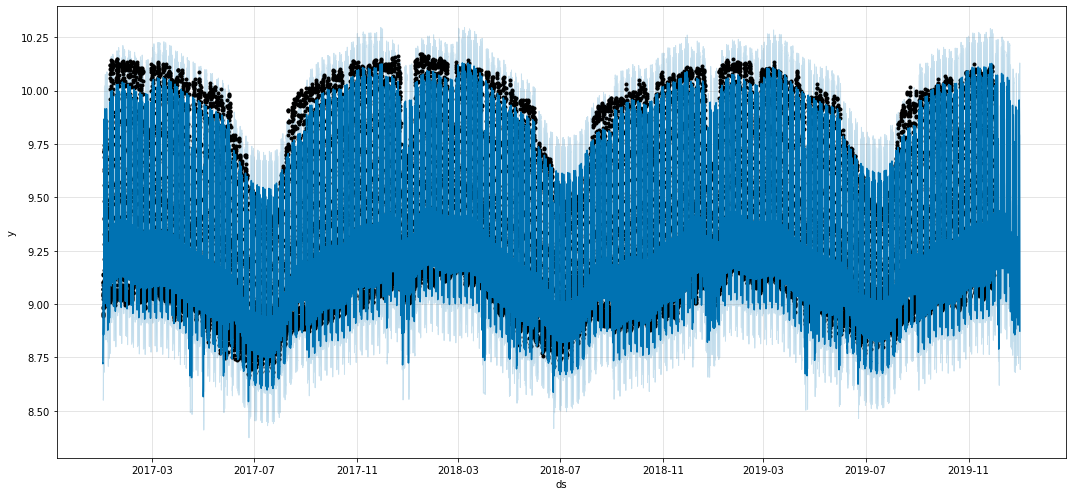

In [25]:
fig1 = model_final.plot(forecast, figsize=(15,7))

Note that for Prophet models, the wider the blue bands (relative to the predictions), the more likely the model is overfit. Here, we see that this is not the case. Now, we evaluate the model on the test set:

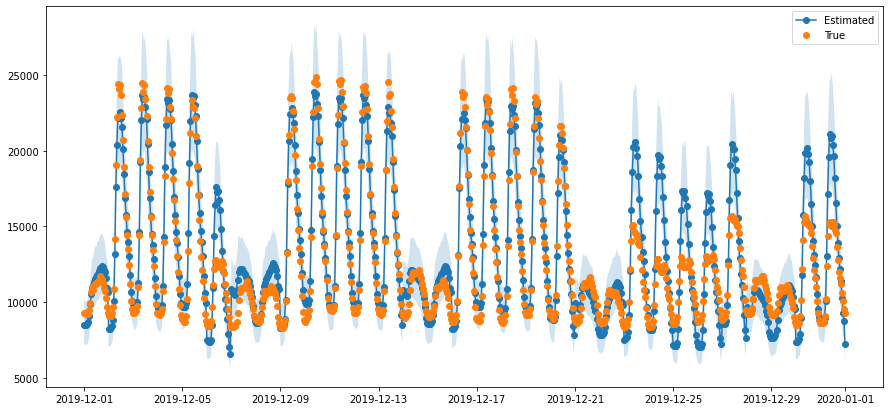

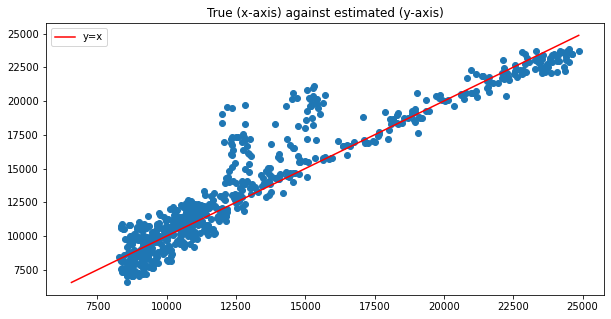

In [26]:
plot(to_exp(forecast, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(test, ['y']), '2019-12-01 00:00:00', '2020-01-01 00:00:00')

Visually, it seems like the model is a good fit although it overpredicts on Christmas holidays. Now we need to check the error of the model on the test set.

In [28]:
from sklearn.metrics import mean_squared_error

ytrue = to_exp(test, ['y'])['y']
ypred = to_exp(forecast, ['yhat']).set_index('ds').loc['2019-12-01 00:00:00':'2020-01-01 00:00:00'].reset_index()['yhat']
rmse = np.sqrt(mean_squared_error(ytrue, ypred))

print(f"The root mean squared error of the better model is: {rmse:.2f}")
print(f"The root mean squared error of the better model is: {mape(ytrue, ypred):.2f}")

The root mean squared error of the better model is: 1575.28
The root mean squared error of the better model is: 0.09


We could also repeat the same procedure for the default model above.

In [29]:
train, test = train_val_test_split(df, validation=False)
m = Prophet(interval_width=0.95)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

In [30]:
ypred2 = forecast.set_index('ds').loc['2019-12-01 00:00:00':'2020-01-01 00:00:00'].reset_index()['yhat']
rmse2 = np.sqrt(mean_squared_error(test['y'], ypred2))
print(f"The root mean squared error of the default model is: {rmse2:.2f}")
print(f"The root mean squared error of the default model is: {mape(test['y'], ypred2):.2f}")

The root mean squared error of the default model is: 2673.60
The root mean squared error of the default model is: 0.18


The MAPE of the better model is half that of the default model. The RMSE is also much lower. We successfully improved on the default model.

The purpose of the validation set was to help tune the hyperparameters of the Prophet models. This is not of great importance to this project, but we could try doing it in the future.